# Visualizing Wildfire Scars: False Color Analysis of the Eaton and Palisades Fires (2025)
**Author: Melannie Moreno Rolón**

You can access the link to the GitHub Repository for this project [here](https://github.com/mmorenorolon/eds220-hwk4.git).

### Purpose:
This notebook visualizes the fire scars left by the Palisades and Eaton fires that struck Los Angeles in January 2025. Using false-color imagery, we monitor the impacts of these wildfires by assigning infrared bands to visible colors. This approach highlights vegetation health, burn scars, and the overall extent of the damage. Ultimately, the goal is to leverage data science techniques to support ongoing environmental monitoring efforts.

### Highlights:
- **Fire Perimeter Exploration**: Import and examine perimeter shapefiles, check coordinate reference system (CRS) and confirm projection type.

- **NetCDF Data Handling**: Load Landsat 8 surface reflectance bands (RGB, NIR, SWIR) with `xr.open_dataset()`, inspect variables, dimensions, and coordinates.

- **Geospatial Restoration**: Recover CRS information from the spatial_ref attribute and apply it using `rio.write_crs()` to ensure proper geospatial alignment.

- **Image Creation & Visualization**:

    - Generate a true color image using RGB bands, handle NaN values and adjust scaling for clouds.

    - Create a false color image using SWIR, NIR and Red bands to highlight vegetation health and burn scars.

    - Overlay fire perimeters on the false color image with titles, legends and annotations for clear interpretation.


### About the Data: Datasets Description

#### Landsat Data:
The NetCDF dataset `landsat8-2025-02-23-palisades-eaton.nc` contains atmospherically corrected surface reflectance data from the Landsat 8 satellite, published on February 23, 2025 through the [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2). It includes key spectral bands (red, green, blue, near-infrared, and shortwave infrared) clipped to the perimeters of the Eaton and Palisades Fires in Los Angeles County. The dataset stores geospatial metadata in the `spatial_ref` variable. With a spatial resolution of 30 meters, this dataset supports the creation of true color and false color composites to assess vegetation health, burn severity and the extent of fire scars. 

Date Accessed: 11/19/2025

#### Fire Perimeter Data:
The Palisades and Eaton Dissolved Fire Perimeters (2025) dataset, published on January 21, 2025 by the County of Los Angeles, provides dissolved boundary polygons for the Eaton and Palisades Fires. Derived from the NIFC FIRIS fire service, which originally contained daily perimeter snapshots, the boundaries were merged to create a single burn perimeter for each fire. One Eaton record (mission 2025-CALAC-009087) was excluded because buffered “destroyed” points did not reliably represent burned areas. The dataset is hosted on [ArcGIS Hub](https://hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about) and includes geospatial layers for both fire perimeters, which supports wildfire impact analysis, mapping and environmental monitoring.

Date Accessed: 11/19/2025

### References:
Microsoft. (2025). *landsat8-2025-02-23-palisades-eaton.nc (Version 1.0) [Dataset]*. Microsoft Planetary Computer. https://planetarycomputer.microsoft.com

County of Los Angeles. (2025). *Palisades and Eaton dissolved fire perimeters (Version 1.0) [Dataset]*. ArcGIS Hub. https://hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about

In [1]:
# Import libraries
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

In this step, we loaded the Python packages used throughout the notebook. These libraries provide tools for working with geospatial raster and vector data, plotting imagery, handling coordinate reference systems (CRS), and managing arrays and tables. This foundation is necessary before reading the fire perimeter shapefiles and Landsat NetCDF imagery.

#### 2. Fire Perimeter Data Exploration
#### Eaton Fire Perimeter

#### Loading the Eaton Fire Perimeter
We begin by loading the Eaton Fire perimeter shapefile. This allows us to inspect the geometry structure, attribute fields, and CRS. Understanding the perimeter data ensures that it will align properly with the Landsat imagery later in the notebook.


In [2]:
# Read in Eaton fire perimeter data
eaton_fire = gpd.read_file(os.path.join('data','Eaton_Perimeter_20250121','Eaton_Perimeter_20250121.shp'))

# View the first five rows of the `eaton_fire` geodataframe
eaton_fire.head()

,OBJECTID,type,Shape__Are,Shape__Len,geometry
0,1,Heat Perimeter,2206.265625,270.199719,"POLYGON ((-13146936.686 4051222.067, -13146932..."
1,2,Heat Perimeter,20710.207031,839.204218,"POLYGON ((-13150835.463 4052713.929, -13150831..."
2,3,Heat Perimeter,3639.238281,250.304502,"POLYGON ((-13153094.697 4053057.596, -13153113..."
3,4,Heat Perimeter,1464.550781,148.106792,"POLYGON ((-13145097.740 4053118.235, -13145100..."
4,5,Heat Perimeter,4132.753906,247.960744,"POLYGON ((-13153131.126 4053196.882, -13153131..."


Next, we examine the data types of each column, the number of features, and the geometry type.  
This helps verify that the dataset is clean, contains the expected polygon boundaries, and is consistent with the Palisades dataset that we will be merging.

In [3]:
# Print the data type of the `eaton_fire` geodataframe 
print(type(eaton_fire))

<class 'geopandas.geodataframe.GeoDataFrame'>


Check the data types of the variables in the dataset.

In [4]:
# Check the data type of each column
eaton_fire.dtypes

OBJECTID         int64
type            object
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object

View the number of rows and columns of the geodataframe. 

In [5]:
# Check the dimensions of the geodataframe
eaton_fire.shape

(20, 5)

We can streamline repetitive code by creating functions. In this analysis, it is important that all know what the geodataframes geometry typees, which we will have to check for more than once. The following function checks for the geometry types of any given geodataframe. 

In [6]:
# Create function that checks the geometry types of the of the geodataframe
def check_polygons(gdf):
    geometry_types = gdf.geometry.geom_type.unique()
    
    if len(geometry_types) == 1:
        print(f"All features are: {geometry_types[0]}")
    else:
        print(f"Multiple feature types: {', '.join(geometry_types)}")

In [7]:
# Check the geometry types of the dataframe
check_polygons(eaton_fire)

All features are: Polygon


The following code checks for the CRS of the geodataframe. Since we will be subsequently merging the Palisades perimeter with the Eaton perimeter, it is important to know what the CRS of each dataframe is.

In [8]:
# Examine CRS details
print('Ellipsoid: ', eaton_fire.crs.ellipsoid)
print('Datum: ', eaton_fire.crs.datum)
print('Is geographic?: ', eaton_fire.crs.is_geographic)
print('Is projected?: ', eaton_fire.crs.is_projected)

Ellipsoid:  WGS 84
Datum:  World Geodetic System 1984 ensemble
Is geographic?:  False
Is projected?:  True


In [9]:
# Access the CRS of the GeoDataFrame
eaton_fire.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Visualizing the Eaton Fire Boundary
Plotting the perimeter provides a quick visual confirmation that the shapefile loaded correctly and displays a valid burn perimeter. This preview also helps situate the fire relative to the landscape we will analyze using satellite data.


<Axes: >

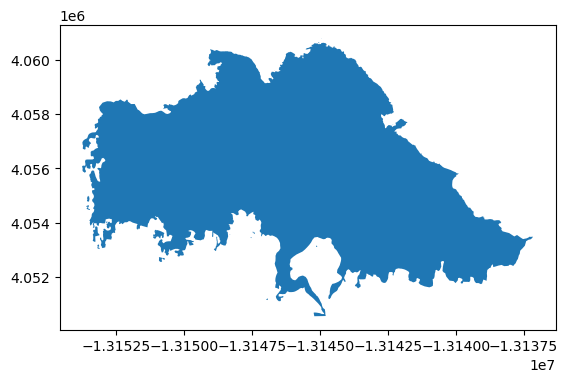

In [10]:
# Take a look at the `eaton_fire` polygon
eaton_fire.plot()

##### Palisades Fire Perimeter Data

We repeat the same process for the Palisades Fire. Examining both datasets individually helps ensure compatibility before merging them into a single GeoDataFrame.

In [11]:
# Read in Palisades fire perimeter data
palis_fire = gpd.read_file(os.path.join('data','Palisades_Perimeter_20250121', 'Palisades_Perimeter_20250121.shp'))

# View the first five rows of the palis_fire perimeter geodataframe
palis_fire.head()

,OBJECTID,type,Shape__Are,Shape__Len,geometry
0,1,Heat Perimeter,1182.082031,267.101144,"POLYGON ((-13193543.302 4032913.077, -13193543..."
1,2,Heat Perimeter,2222.488281,185.498783,"POLYGON ((-13193524.155 4033067.953, -13193524..."
2,3,Heat Perimeter,21.011719,22.412814,"POLYGON ((-13193598.085 4033158.222, -13193598..."
3,4,Heat Perimeter,214.992188,76.639180,"POLYGON ((-13193654.249 4033146.033, -13193656..."
4,5,Heat Perimeter,44203.453125,1569.259764,"POLYGON ((-13194209.580 4033236.320, -13194209..."


In [12]:
# Print the data type of the `palis_fire` geodataframe 
print(type(palis_fire))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [13]:
# Check the data type of each column
eaton_fire.dtypes

OBJECTID         int64
type            object
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object

In [14]:
# Check the dimensions of the geodataframe
palis_fire.shape

(21, 5)

In [15]:
# # Check the geometry types of the dataframe
check_polygons(palis_fire)

All features are: Polygon


In [16]:
# Examine CRS details
print('Ellipsoid: ', palis_fire.crs.ellipsoid)
print('Datum: ', palis_fire.crs.datum)
print('Is geographic?: ', palis_fire.crs.is_geographic)
print('Is projected?: ', palis_fire.crs.is_projected)

Ellipsoid:  WGS 84
Datum:  World Geodetic System 1984 ensemble
Is geographic?:  False
Is projected?:  True


In [17]:
# Access the CRS of the GeoDataframe
palis_fire.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

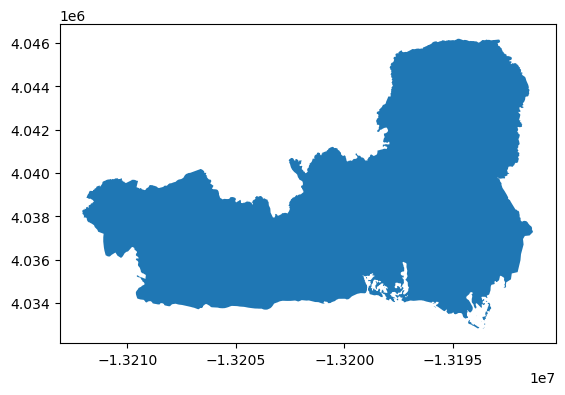

In [18]:
# Take a look at the `palis_fire` polygon
palis_fire.plot()

### Merging Eaton and Palisades Perimeters
Because both perimeter shapefiles share the same CRS and attribute structure, we can safely merge them into one GeoDataFrame.  
This combined dataset (`fires`) streamlines visualization and overlay operations later in the notebook. The following code verifies that the CRS's are the same and share the same columns. In addition, we add a new column to be able to differentiate within our merged geodataframe which geometries correspond to the Palisades and Eaton fire perimeters.


In [19]:
# Check that both geodataframes share the same CRS
assert eaton_fire.crs == palis_fire.crs

In [20]:
# Check that both dataframes share the same column names
eaton_fire.columns == palis_fire.columns

array([ True,  True,  True,  True,  True])

In [21]:
# Add a new column to identify each fire
eaton_fire['fire_name'] = 'Eaton'
palis_fire['fire_name'] = 'Palisades'

In [22]:
# Concatenate both geodataframes
fires = gpd.GeoDataFrame(pd.concat([eaton_fire, palis_fire], ignore_index= True))

# View the first five rows of `fires`
fires.head()

,OBJECTID,type,Shape__Are,Shape__Len,geometry,fire_name
0,1,Heat Perimeter,2206.265625,270.199719,"POLYGON ((-13146936.686 4051222.067, -13146932...",Eaton
1,2,Heat Perimeter,20710.207031,839.204218,"POLYGON ((-13150835.463 4052713.929, -13150831...",Eaton
2,3,Heat Perimeter,3639.238281,250.304502,"POLYGON ((-13153094.697 4053057.596, -13153113...",Eaton
3,4,Heat Perimeter,1464.550781,148.106792,"POLYGON ((-13145097.740 4053118.235, -13145100...",Eaton
4,5,Heat Perimeter,4132.753906,247.960744,"POLYGON ((-13153131.126 4053196.882, -13153131...",Eaton


After merging the both boundary datasets, we verify our new geodaframe's structure, such as the number of rows and columns, bounds, and column names.

In [23]:
# Check the dimensions of the new geodataframe 
fires.shape

(41, 6)

In [24]:
# Obtain the geographic extent of `fires`
fires.total_bounds

array([-13212082.926963  ,   4032822.81114236, -13137152.8556185 ,
         4060781.94401591])

In [25]:
# View the names of the `fires` geodataframe
fires.columns

Index(['OBJECTID', 'type', 'Shape__Are', 'Shape__Len', 'geometry',
       'fire_name'],
      dtype='object')

### Cleaning Column Names  
To make the dataset easier to work with, we standardize column names by converting them to lowercase and renaming fields such as `shape_are` to`area` and `shape_len` to `length`. Clean column names reduce ambiguity and improve readability in subsequent analyses.


In [26]:
# Simplify the geodataframe columns
fires.columns = (
    fires.columns
    .str.strip()          # remove leading or trailing spaces
    .str.lower()          # convert to lowercase
    .str.replace("__", "_")  # replace double underscores with single
)

# View the simplified geodataframe columns
fires.columns

Index(['objectid', 'type', 'shape_are', 'shape_len', 'geometry', 'fire_name'], dtype='object')

In [27]:
# Rename the `shape_are` and `shape_len` columns
fires= fires.rename(columns={
    "shape_are": "area",
    "shape_len": "length"
})

# View the dataframe with the renamed columns
fires.columns

Index(['objectid', 'type', 'area', 'length', 'geometry', 'fire_name'], dtype='object')

Finally, we conduct a final CRS check and create a preliminary plot the boundaries of both perimeters from our new geodataframe.

In [28]:
fires.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

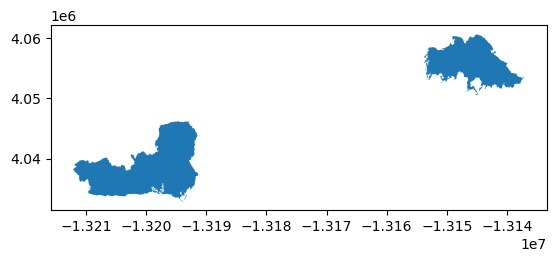

In [29]:
# Plot the fires geodataframe
fires.plot()

#### Summary of Preliminary Data Exploration for Fire Perimeters GeoDataFrame
The `fires` dataframe is a  `geopandas.geodataframe`. The geodataframe has one feature type (Polygon). It has a projected CRS of EPSG:3857. The units of the coordinates are in meters. The data types of each column are: string (object), integer (int64), floating decimal numbers (float64) for the a of  area of each fire perimeter, and geometry. The dimensions of the geodataframe are 41 rows and 5 columns. The total bounds of the geodataframe are (-180.0, -85.06, 180.0, 85.06).  

### 3. NetCDF data import and exploration

#### Loading the Landsat 8 Bands
Here, we load the individual spectral bands from the Landsat 8 dataset. Each band represents reflectance in a different portion of the electromagnetic spectrum. Because false color imagery relies on assigning SWIR, NIR, and Red bands to visible colors, loading these bands correctly is essential for constructing the final composite.


In [30]:
# Read in Landsat 8 data
landsat8 = xr.open_dataset('data/landsat8-2025-02-23-palisades-eaton.nc')

#### Inspecting Variables and Metadata
Calling `.info()` provides an overview of all available variables (such as red, green, blue, NIR, and SWIR bands), along with their shapes, units, and stored metadata. This step ensures we understand how the dataset is stored and which variables are required for color composite creation.


In [31]:
# Obtain detailed information about variables and data types
landsat8.info()          

xarray.Dataset {
dimensions:
	y = 1418 ;
	x = 2742 ;

variables:
	float64 y(y) ;
		y:units = metre ;
		y:resolution = -30.0 ;
		y:crs = EPSG:32611 ;
		y:axis = Y ;
		y:long_name = y coordinate of projection ;
		y:standard_name = projection_y_coordinate ;
	float64 x(x) ;
		x:units = metre ;
		x:resolution = 30.0 ;
		x:crs = EPSG:32611 ;
		x:axis = X ;
		x:long_name = x coordinate of projection ;
		x:standard_name = projection_x_coordinate ;
	datetime64[ns] time() ;
	float32 red(y, x) ;
		red:grid_mapping = spatial_ref ;
	float32 green(y, x) ;
		green:grid_mapping = spatial_ref ;
	float32 blue(y, x) ;
		blue:grid_mapping = spatial_ref ;
	float32 nir08(y, x) ;
		nir08:grid_mapping = spatial_ref ;
	float32 swir22(y, x) ;
		swir22:grid_mapping = spatial_ref ;
	int64 spatial_ref() ;
		spatial_ref:crs_wkt = PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["

The `keys()` method allows us to view the list of variable names in the landsat8 geodataframe. 

In [32]:
# View the list of variable names
landsat8.keys()

KeysView(<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...)

Another way to view just the list of variables without metadata attached to them is using the `list()` method. We do the same for the dataframe's coordinates.

In [33]:
# Check the list of data variables
list(landsat8.data_vars) 

['red', 'green', 'blue', 'nir08', 'swir22', 'spatial_ref']

In [34]:
# View the list of coordinate variables
list(landsat8.coords)        

['y', 'x', 'time']

We checked for missing values using the `isnull().sum()` chained methods.

In [35]:
# View the number of missing values within the dataset
landsat8.isnull().sum()

<xarray.Dataset> Size: 32B
Dimensions:      ()
Coordinates:
    time         datetime64[ns] 8B ...
Data variables:
    red          int32 4B 0
    green        int32 4B 1
    blue         int32 4B 109
    nir08        int32 4B 0
    swir22       int32 4B 0
    spatial_ref  int32 4B 0

To display all the variables with metadata attached, we used the `.variables` attribute.

In [36]:
# Obtain variables including metadata
landsat8.variables              

Frozen({'y': <xarray.IndexVariable 'y' (y: 1418)> Size: 11kB
array([3799050., 3799020., 3798990., ..., 3756600., 3756570., 3756540.])
Attributes:
    units:          metre
    resolution:     -30.0
    crs:            EPSG:32611
    axis:           Y
    long_name:      y coordinate of projection
    standard_name:  projection_y_coordinate, 'x': <xarray.IndexVariable 'x' (x: 2742)> Size: 22kB
array([334410., 334440., 334470., ..., 416580., 416610., 416640.])
Attributes:
    units:          metre
    resolution:     30.0
    crs:            EPSG:32611
    axis:           X
    long_name:      x coordinate of projection
    standard_name:  projection_x_coordinate, 'time': <xarray.Variable ()> Size: 8B
[1 values with dtype=datetime64[ns]], 'red': <xarray.Variable (y: 1418, x: 2742)> Size: 16MB
array([[10242.,  9886., 10142., ...,  8478.,  9179.,  9088.],
       [10338., 10263., 10255., ...,  8299.,  8645.,  8662.],
       [10312., 10153., 10300., ...,  9382.,  9123.,  8997.],
       ...,


#### Quick Band Visualization
Plotting a single band provides an initial visual check and helps confirm that the dataset was read correctly. This is a useful diagnostic step before building composite imagery.


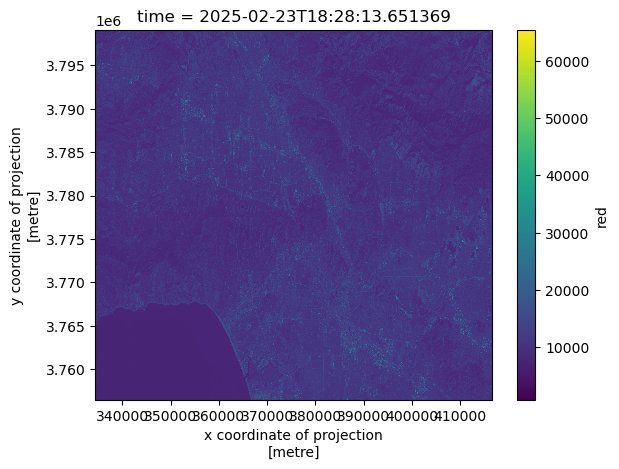

In [37]:
# Quick visualization of the red band of the dataset
landsat8['red'].plot()

#### Summary of Preliminary Exploration for `landsat8`
 The dataset shows that the blue band contains 109 missing values, while the green band has only one; all other variables are complete with no missing data. The spatial dimensions are 1418 y‑coordinates by 2742 x‑coordinates. Band values are stored as integers, whereas the time variable is in datetime format. All measurements are expressed in meters, and the dataset is referenced to CRS EPSG:32611. 

### 4. Restoring Geospatial Information


In [38]:
# Print the CRS of `landsat8` with `rio.crs`
print(landsat8.rio.crs)

None


In [39]:
# Print the CRS by using accesing the spatial_ref.crs_wkt attribute of the dataset
landsat8.spatial_ref.crs_wkt

'PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]'

#### Restoring Missing Spatial Reference Information
Although the Landsat NetCDF file contains a `spatial_ref` variable, the CRS is not automatically recognized by rioxarray.  
Here we extract the WKT-formatted CRS stored inside `spatial_ref` and write it back to the dataset using `.rio.write_crs()`.  
This step is essential for aligning the raster dataset with the fire perimeter polygons.


In [40]:
# Recover the geospatial information and the spatial reference information 
landsat8.rio.write_crs('EPSG:32611', inplace=True)

# Print the CRS of the updated dataset
print(landsat8.rio.crs)

EPSG:32611


### 5. True Color Image

#### Creating a True Color Image
To generate a natural-looking image of the landscape, we combine the red, green, and blue bands.  
Because clouds and bright targets can skew pixel values, we use the `robust=True` parameter to rescale the display range and improve visualization. We also address missing values by replacing NaNs with zeros to avoid rendering warnings.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


c:\Users\Melannie\.conda\envs\eds220-env\Lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


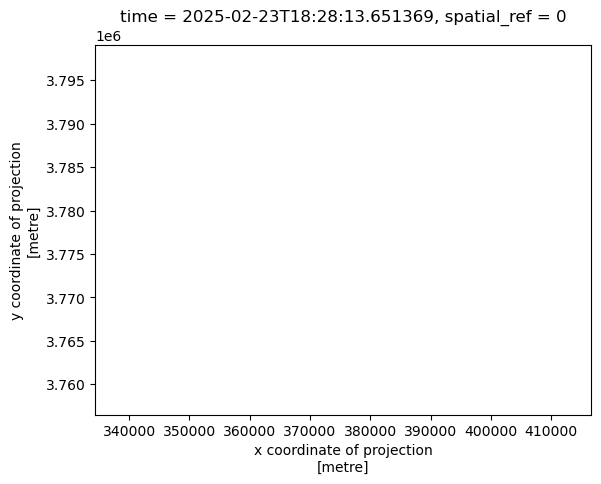

In [41]:
# a. Plot the red, green, and blue variables 
landsat8[['red', 'green', 'blue']].to_array().plot.imshow()

c:\Users\Melannie\.conda\envs\eds220-env\Lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


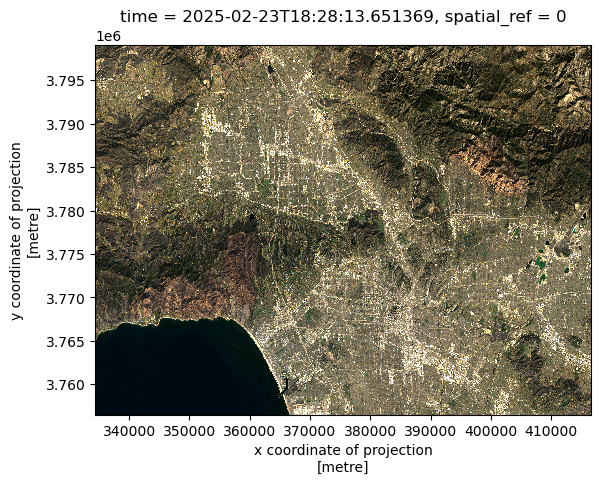

In [42]:
# b. Adjust the scale used for plotting the bands to get a true color image by setting the robust parameter to True
landsat8[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

In [43]:
# c. Identify which bands have missing values 
landsat8.isnull().sum()


<xarray.Dataset> Size: 32B
Dimensions:      ()
Coordinates:
    time         datetime64[ns] 8B 2025-02-23T18:28:13.651369
    spatial_ref  int32 4B 0
Data variables:
    red          int32 4B 0
    green        int32 4B 1
    blue         int32 4B 109
    nir08        int32 4B 0
    swir22       int32 4B 0

The green and blue bands have missing values.

In [44]:
# d. Substitute any missing values in the dataset with zeroes
landsat8_filled = landsat8.fillna(0)

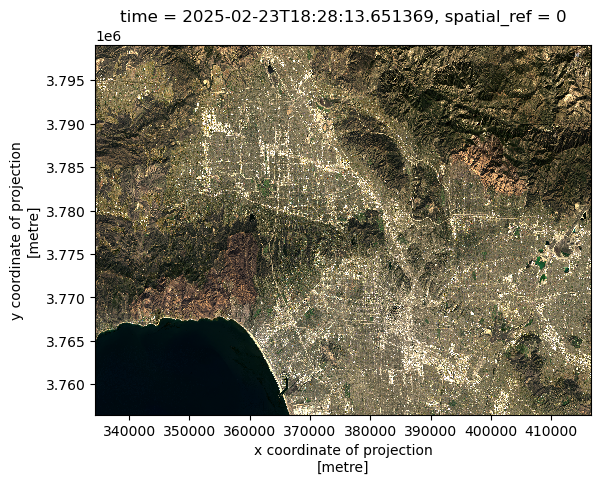

In [45]:
# e. Create a true color image without warnings
landsat8_filled[['red','green','blue']].to_array().plot.imshow(robust=True)

#### True Color Image Generation Summary
The output for our first true color image was a blank plot with two warnings. Because clouds are extremely bright, they stretch the scale, so the non-cloud pixels are squeezed into a tiny part of the range. As a result, the entire image looks blank. After setting the `robust` parameter to True, this tells xarray to ignore the extreme outliers. This fixed the first warning. The second warning mentioned invalid values, likely due to the presence of missing values. To identify which bands contain missing values, I used `landsat8.isnull().sum()`, which counts the number of missing pixels in each data variable. This revealed that the green and blue bands included NaN values and allowed us to understand why the warning occurred. To remove the NaN-related plotting warning, I applied `fillna(0)` to the dataset and then generated the true color image using the filled data. This ensured that the image plotted without warnings.

### 6. False Color Image

### Creating the False Color Composite
To highlight burn scars and vegetation health, we combine three Landsat bands into a false color image:
- **SWIR** → **Red channel**
- **NIR** → **Green channel**
- **Red** → **Blue channel**

This band arrangement enhances the visibility of burned regions and stressed vegetation. This visualization will make it easier to interpret fire impacts across the Palisades and Eaton areas.


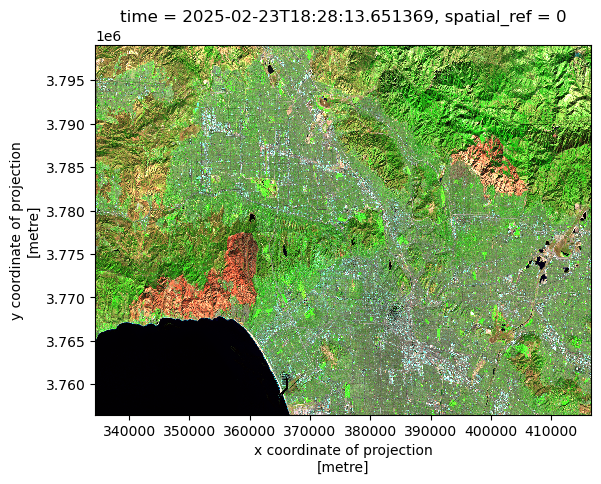

In [46]:
# Plot the short-wave infrared (swir22), near-infrared, and red variables (in that order)
landsat8_filled[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True)

### 7. Map 

### Reprojecting Raster and Vector Data
The Landsat imagery and fire perimeter shapefiles may use different coordinate reference systems (CRS).  
To properly overlay perimeter polygons on the raster data, we reproject both datasets into a common CRS.  
This ensures that pixel locations align with fire boundaries on the map.


In [47]:
# Verify that CRS's match
fires.crs == landsat8_filled.rio.crs

False

In [48]:
# Reproject the `fires` polygons to the landsat dataset
fires = fires.to_crs(landsat8_filled.rio.crs)

In [49]:
# Check that the CRS's match after reprojection
fires.crs == landsat8.rio.crs

True

In [50]:
print(fires.total_bounds)

[ 344406.73232733 3766517.4675391   406646.84925345 3789057.23010932]


#### Mapping Fire Perimeters on the False Color Composite
In this final visualization, we overlay the Eaton and Palisades fire boundaries on the false color image.  
This map reveals which areas exhibit increased SWIR reflectance, which is a strong indicator of recent burns, and confirms alignment with official fire perimeters. Text annotations help distinguish each fire footprint.


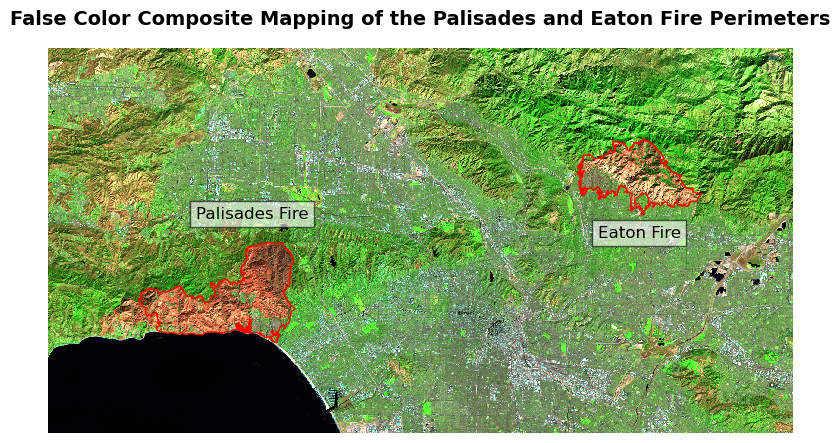

<Figure size 640x480 with 0 Axes>

In [51]:
# Create empty plot
fig, ax = plt.subplots(figsize=(11,5))
ax.axis('off')

# Show the shortwave infrared/near-infrared/red false color image together with both fire perimeters
landsat8_filled[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True, ax = ax)
fires.plot(ax=ax, 
           legend=True,
           color = 'none',
           edgecolor='red')

# Add a title
ax.set_title("False Color Composite Mapping of the Palisades and Eaton Fire Perimeters", fontsize=14, fontweight='bold')

# Add text annotation for the Eaton Fire
ax.text(0.85, 0.5, "Eaton Fire",
        transform=ax.transAxes,  # relative to axes (0–1)
        ha="right", va="bottom",
        fontsize=12, bbox=dict(facecolor="white", alpha=0.6))

# Add text annotation for the Palisades Fire
ax.text(0.35, 0.55, "Palisades Fire",
        transform=ax.transAxes,  # relative to axes (0–1)
        ha="right", va="bottom",
        fontsize=12, bbox=dict(facecolor="white", alpha=0.6))

# Display plot
plt.show()
plt.tight_layout()

**More About the Use of False Color Imagery in this Figure**

The image above used the shortwave infrared (SWIR), near-infrared (NIR), and red band combination, which highlights the visibility of burned areas and stress on vegetation. In this false color scheme, healthy vegeation appears in bright green
In this combination, shortwave infrared (SWIR) is assigned to the red display channel, near-infrared (NIR) to green, and red light to blue. Burn scars appear in deep red tones, while SWIR reflectance increases after vegetation burns due to the loss of water content and exposure of burned soil. Vegetation reflects strongly in the NIR, which is mapped to the green channel in this composite, while Urban areas and developed land appear in shades of cyan or gray. Water appears very dark or black because both SWIR and NIR are almost completely absorbed by water. These spectral relationships allow the burned areas from the Palisades and Eaton fires to stand out strongly against the surrounding landscape. The fire perimeters (shown as transparent red polygons) align with the regions of intense SWIR reflectance. This map confirms the extent of the burn scars captured by Landsat.